# Architecture of Classification Neural Network  
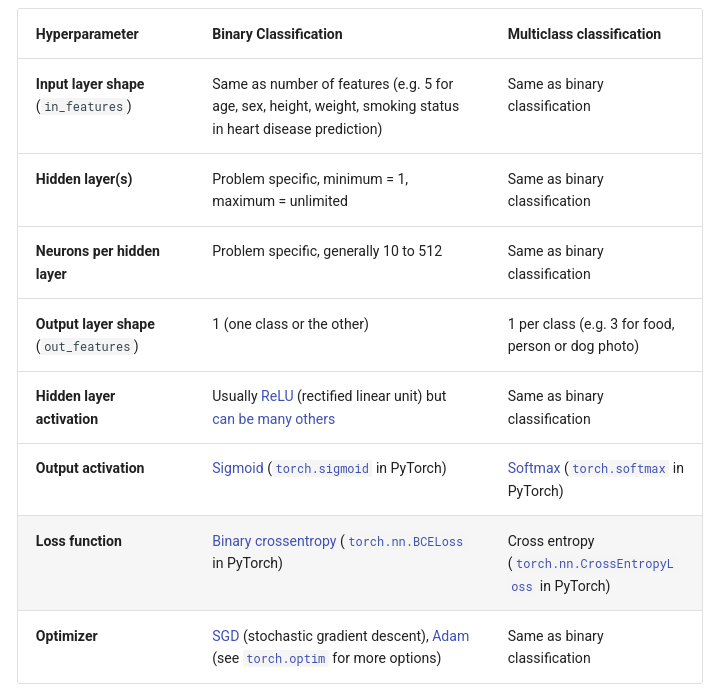

# Make Classification data and get it ready

In [30]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [31]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [32]:
import pandas as pd

circles = pd.DataFrame({'X1':X[:,0],'X2':X[:,1],'y':y})
circles.head(10)

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [33]:
circles.y.value_counts()

y
1    500
0    500
Name: count, dtype: int64

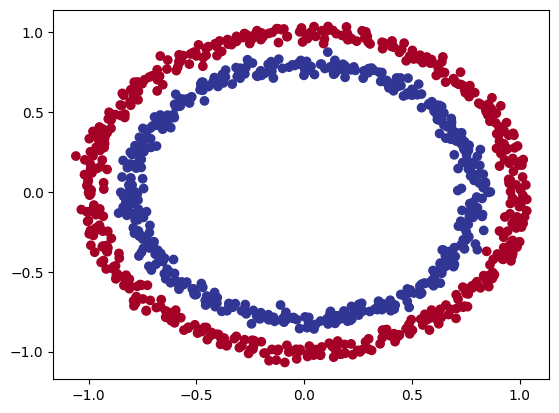

In [34]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

### 1. Input and Output Shapes
Always ask **"What shapes are my inputs and what shapes are my outputs?"**

In [35]:
X.shape, y.shape

((1000, 2), (1000,))

In [36]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


**This tells us the second dimension for X means it has two features (vector) where as y has a single feature (scalar).**

### 2. Turn data into tensors and create train and test splits


In [37]:
import torch

In [38]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:10], y[:10]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967],
         [-0.4796,  0.6764],
         [-0.0136,  0.8033],
         [ 0.7715,  0.1478],
         [-0.1693, -0.7935],
         [-0.1215,  1.0215]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

# Building a model
1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of `nn.Module`).
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of X and y.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. **Instantiates the model class and sends it to the target device**
5. **Try predicting on the test set without training the model and compare with the labels of test set** **(IMPORTANT)**


In [40]:
import torch.nn as nn


In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using device: {device}")

Using device: cpu


In [43]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2,out_features=5)
        self.linear_layer2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer2(self.linear_layer1(x))

In [44]:
model_0 = CircleModelV0()
model_0

CircleModelV0(
  (linear_layer1): Linear(in_features=2, out_features=5, bias=True)
  (linear_layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_0 = model_0.to(device=device)

### 1. Visualize the model impact in tensorflow
We can visualize the impact of neural network in the following link.
**[Tensorflow playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.09874&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)**

### 2. `nn.Sequential()` 
- Performs a forward pass computation of the input data through the layers in the order they appear.
- Why not use always?  
    it always runs in sequential order. If you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom `nn.Module` subclass.

In [16]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

In [17]:
model_0 = model_0.to(device=device)

In [18]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

### 3. Predict in test set without training
- **Before training and before inference, always keep the data and model in the same device** **(IMPORTANT)**

In [19]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
untrained_preds[:10]

tensor([[-0.6596],
        [-0.8215],
        [-0.2941],
        [-0.7629],
        [-0.3876],
        [-0.4857],
        [-0.8674],
        [-0.7890],
        [-0.2907],
        [-0.8334]], device='cuda:0')

In [20]:
y_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

### 4. Setup Loss function and optimizer

PyTorch has two binary cross entropy implementations:

1. `torch.nn.BCELoss()` - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. `torch.nn.BCEWithLogitsLoss()` - This is the same as above except **it has a sigmoid layer (nn.Sigmoid)** built-in (we'll see what this means soon).

Which one should you use?
1. The documentation for `torch.nn.BCEWithLogitsLoss()` states that it's more numerically stable than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer.
2. However for advanced usage, you may want to separate the combination of `nn.Sigmoid` and `torch.nn.BCELoss()`


In [21]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

### 5. Evaluation metics
- If a loss function measures how wrong your model is, I like to think of evaluation metrics as measuring how right it is.


In [29]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct/len(y_pred)) * 100
    return acc

In [23]:
torch.eq(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[1, 1], [4, 4]]))

tensor([[ True, False],
        [False,  True]])

In [24]:
torch.eq(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[1, 1], [4, 4]])).sum() #total number of Trues

tensor(2)

In [25]:
torch.eq(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[1, 1], [4, 4]])).sum().item() #tensor to scalar

2

# Train model

### 1. Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)
 - **logits** = the raw outputs of our model are often referred to as logits (y = x * W + b)
 - we converted our model's raw outputs (logits) to prediction probabilities using a sigmoid activation function.
 - Then converted the prediction probabilities to prediction labels by rounding them.

In [26]:
# view the first five outcomes of the forward pass on the test data
y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[-0.6596],
        [-0.8215],
        [-0.2941],
        [-0.7629],
        [-0.3876]], device='cuda:0', grad_fn=<SliceBackward0>)

In [27]:
Y_pred_probs = torch.sigmoid(y_logits)
Y_pred_probs[:5]

tensor([[0.3408],
        [0.3054],
        [0.4270],
        [0.3180],
        [0.4043]], device='cuda:0', grad_fn=<SliceBackward0>)

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [29]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(Y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
y_pred_labels

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

### 2. Building a training and testing loop

In [30]:
torch.manual_seed(42)

train_loss = []
test_loss = []
train_acc = []
test_acc = []

#no of epochs
epochs = 100

#put the data to the device
X_train, X_test, y_train, y_test =  X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

#training and testing loop
for epoch in range(epochs):

    #train mode
    model_0.train()

    #forward pass
    y_logits = model_0(X_train).squeeze()

    #logits -> probs
    y_pred_probs = torch.sigmoid(y_logits)

    #probs -> labels
    y_pred_labels = torch.round(y_pred_probs)

    #train accuracy
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred_labels)

    #calculate loss
    loss = loss_fn(y_logits, y_train)

    #zero_grad
    optimizer.zero_grad()

    #backprop
    loss.backward()

    #update weights
    optimizer.step()

    #testing
    model_0.eval()

    #context
    with torch.inference_mode():

        #forward pass
        y_logits_test = model_0(X_test).squeeze()

        #logits -> probs
        y_pred_probs_test = torch.sigmoid(y_logits_test)

        #probs -> labels
        y_pred_labels_test = torch.round(y_pred_probs_test)

        #test accuracy
        acc_test = accuracy_fn(y_true=y_test, y_pred=y_pred_labels_test)

        #calculate loss
        loss_test = loss_fn(y_logits_test, y_test)

        if epoch % 10 == 0:
            train_loss.append(loss)
            test_loss.append(loss_test)
            train_acc.append(acc)
            test_acc.append(acc_test)

            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {loss_test:.5f}, Test acc: {acc_test:.2f}%")

            

Epoch: 0 | Loss: 0.73535, Accuracy: 50.00% | Test loss: 0.72461, Test acc: 50.00%
Epoch: 10 | Loss: 0.70925, Accuracy: 50.00% | Test loss: 0.70159, Test acc: 50.00%
Epoch: 20 | Loss: 0.70025, Accuracy: 44.50% | Test loss: 0.69412, Test acc: 47.50%
Epoch: 30 | Loss: 0.69697, Accuracy: 47.12% | Test loss: 0.69179, Test acc: 50.00%
Epoch: 40 | Loss: 0.69563, Accuracy: 47.62% | Test loss: 0.69115, Test acc: 53.50%
Epoch: 50 | Loss: 0.69499, Accuracy: 49.00% | Test loss: 0.69108, Test acc: 53.00%
Epoch: 60 | Loss: 0.69461, Accuracy: 48.38% | Test loss: 0.69119, Test acc: 53.00%
Epoch: 70 | Loss: 0.69434, Accuracy: 48.75% | Test loss: 0.69135, Test acc: 52.50%
Epoch: 80 | Loss: 0.69414, Accuracy: 49.25% | Test loss: 0.69152, Test acc: 53.00%
Epoch: 90 | Loss: 0.69397, Accuracy: 49.25% | Test loss: 0.69169, Test acc: 53.00%


# Make Predictions and evaluate the model
- Plot model's predictions
- download and import the [helper_functions.py](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py) script from the [Learn PyTorch for Deep Learning](https://github.com/mrdbourke/pytorch-deep-learning) repo.

In [46]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


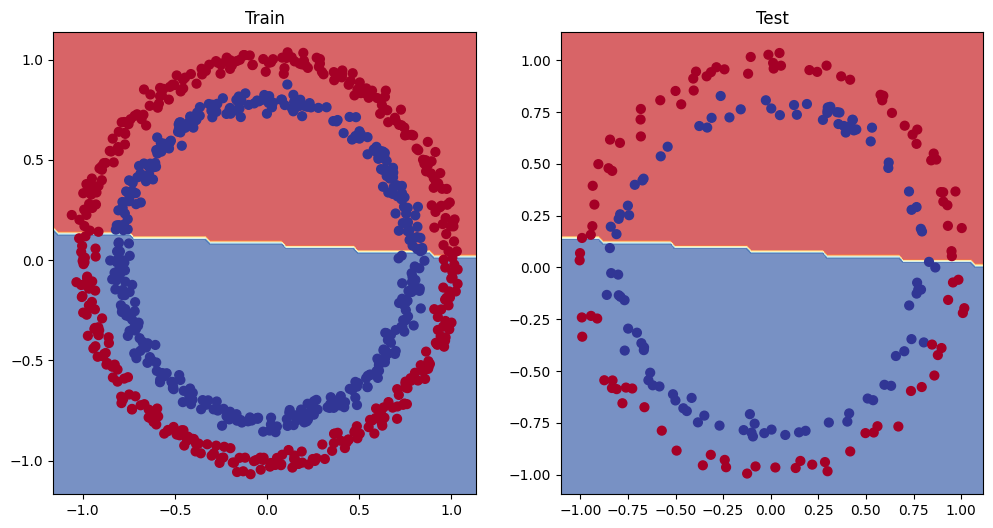

In [32]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

#### Problems
 - It's currently trying to split the red and blue dots using a straight line...
 - In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.

# Improving a model (from a model perspective)
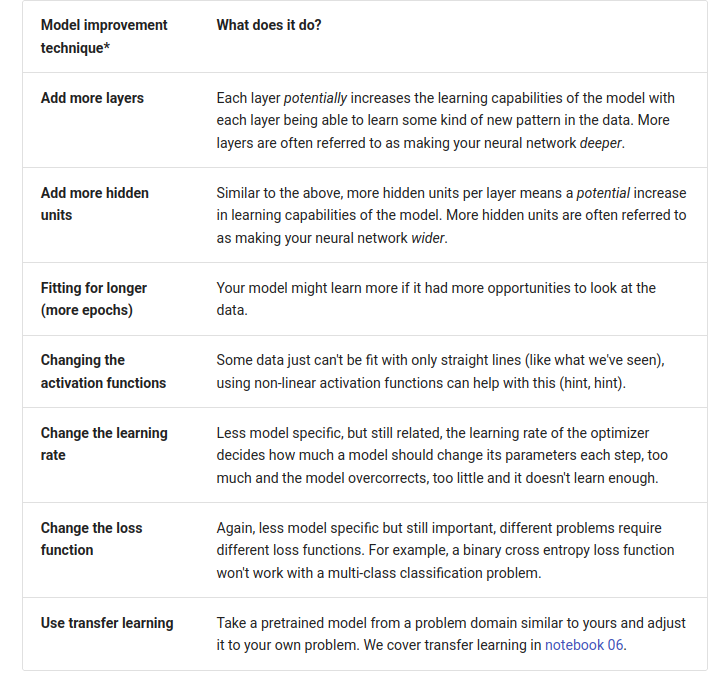  
- And this is also where machine learning's half art half science comes in, there's no real way to know here what the best combination of values is for your project, best to follow the data scientist's motto of "experiment, experiment, experiment".

### 1. Experiment
- fit for longer(epochs = 1000)
- layers more (3)
- hidden units (10)

In [33]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2,out_features=10)
        self.layer2 = nn.Linear(in_features=10,out_features=10)
        self.layer3 = nn.Linear(in_features=10,out_features=1)

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

In [34]:
model_1 = CircleModelV1()
model_1 = model_1.to(device=device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.1
)

In [36]:
torch.manual_seed(42)

train_loss = []
test_loss = []
train_acc = []
test_acc = []

#no of epochs
epochs = 1000

#put the data to the device
X_train, X_test, y_train, y_test =  X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

#training and testing loop
for epoch in range(epochs):

    #train mode
    model_1.train()

    #forward pass
    y_logits = model_1(X_train).squeeze()

    #logits -> probs
    y_pred_probs = torch.sigmoid(y_logits)

    #probs -> labels
    y_pred_labels = torch.round(y_pred_probs)

    #train accuracy
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred_labels)

    #calculate loss
    loss = loss_fn(y_logits, y_train)

    #zero_grad
    optimizer.zero_grad()

    #backprop
    loss.backward()

    #update weights
    optimizer.step()

    #testing
    model_1.eval()

    #context
    with torch.inference_mode():

        #forward pass
        y_logits_test = model_1(X_test).squeeze()

        #logits -> probs
        y_pred_probs_test = torch.sigmoid(y_logits_test)

        #probs -> labels
        y_pred_labels_test = torch.round(y_pred_probs_test)

        #test accuracy
        acc_test = accuracy_fn(y_true=y_test, y_pred=y_pred_labels_test)

        #calculate loss
        loss_test = loss_fn(y_logits_test, y_test)

        if epoch % 100 == 0:
            train_loss.append(loss)
            test_loss.append(loss_test)
            train_acc.append(acc)
            test_acc.append(acc_test)

            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {loss_test:.5f}, Test acc: {acc_test:.2f}%")

            

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


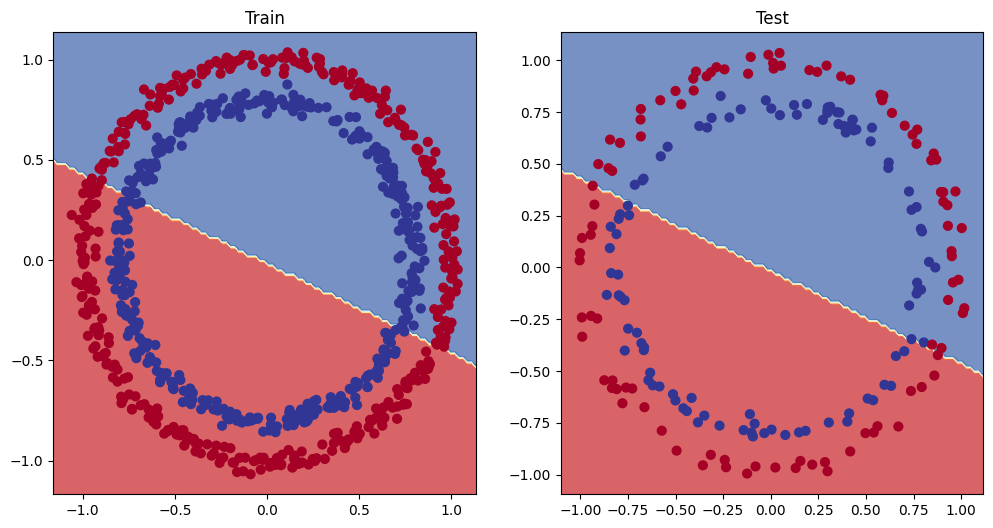

In [37]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 2. See if our model can model linear data (Preparing data to see if our model can model a straight line)

In [38]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [39]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


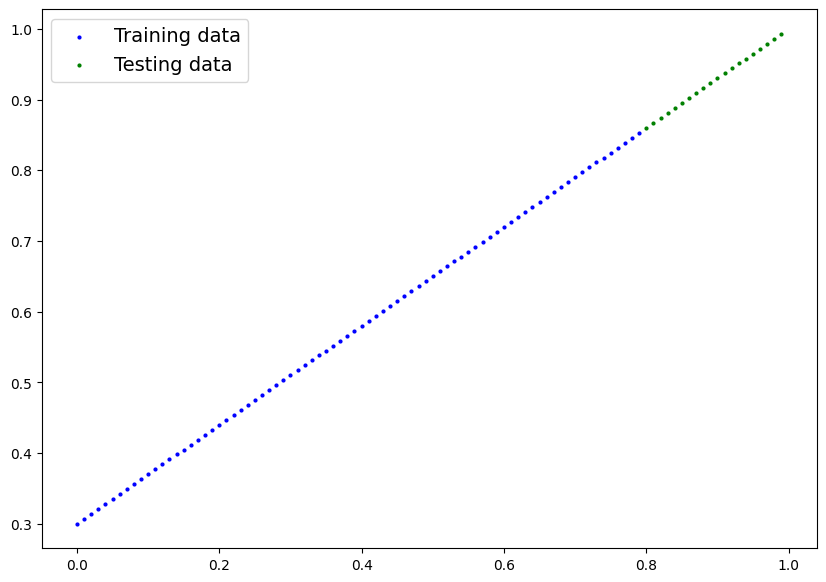

In [40]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

### 3. Adjust the model to fit a straight line
- recreate model_1 but with a loss function suited to our regression data.

In [41]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [42]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [43]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


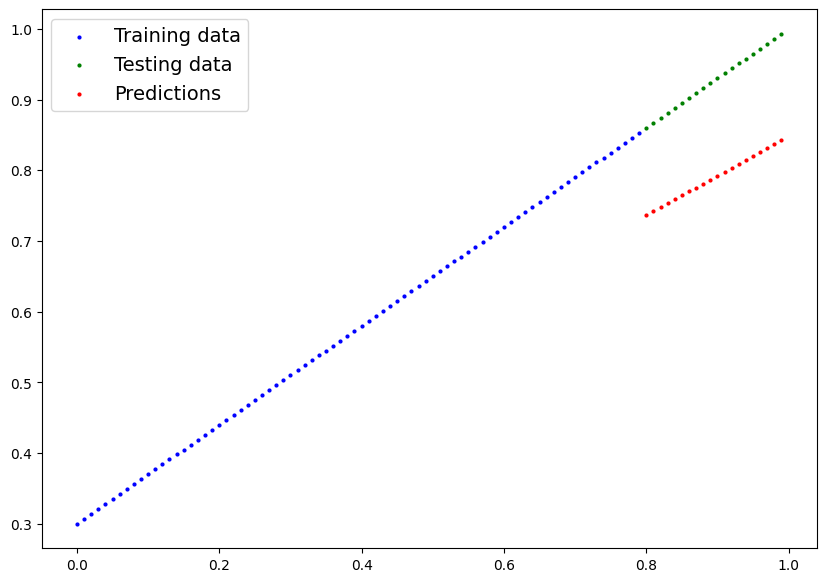

In [44]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

# The missing piece: non-linearity

### 1. Recreating non-linear data(red andblue circles)

In [8]:
import torch
import torch.nn as nn

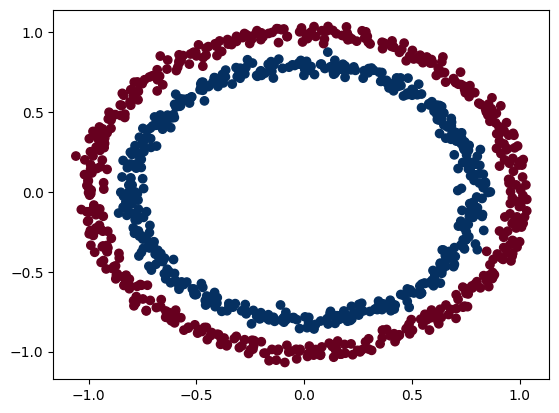

In [9]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [22]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

In [23]:
model_3 = CircleModelV2()
model_3 = model_3.to(device=device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [24]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),lr=0.1)

In [25]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [27]:
torch.manual_seed(42)

#total number of epochs
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#to store metrics and loss
train_loss = []
test_loss = []
train_acc = []
test_acc = []

#loop
for epoch in range(epochs):

    #put model to train mode
    model_3.train()

    #forward pass
    y_logits = model_3(X_train).squeeze()

    #sigmoid
    y_pred = torch.sigmoid(y_logits)

    #y_pred labels
    y_pred_labels = torch.round(y_pred)

    #train acc
    train_accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred_labels)

    #loss
    loss = loss_fn(y_logits, y_train)

    #zero_grad
    optimizer.zero_grad()

    #calculate gradients
    loss.backward()

    #optimize
    optimizer.step()

    #model eval
    model_3.eval()

    with torch.inference_mode():

        y_logits_test = model_3(X_test).squeeze()

        #sigmoid
        y_pred_test = torch.sigmoid(y_logits_test)

        #y_pred labels
        y_pred_labels_test = torch.round(y_pred_test)

        #train acc
        test_accuracy = accuracy_fn(y_test, y_pred_labels_test)

        #loss
        loss_test = loss_fn(y_logits_test, y_test)

        if epoch % 100 == 0:

            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {train_accuracy:.2f}% | Test Loss: {loss_test:.5f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch: 0 | Loss: 0.69289, Accuracy: 50.00% | Test Loss: 0.69312, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69114, Accuracy: 52.88% | Test Loss: 0.69101, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68976, Accuracy: 53.25% | Test Loss: 0.68938, Test Accuracy: 55.50%
Epoch: 300 | Loss: 0.68793, Accuracy: 53.00% | Test Loss: 0.68721, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68513, Accuracy: 52.75% | Test Loss: 0.68408, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68097, Accuracy: 52.75% | Test Loss: 0.67936, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67508, Accuracy: 54.50% | Test Loss: 0.67277, Test Accuracy: 56.50%
Epoch: 700 | Loss: 0.66648, Accuracy: 58.38% | Test Loss: 0.66310, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65140, Accuracy: 64.00% | Test Loss: 0.64738, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62324, Accuracy: 74.00% | Test Loss: 0.62111, Test Accuracy: 79.00%


### 2. Evaluating a model trained with non-linear activation functions

In [28]:
#make predictions
model_3.eval()

with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test)))

y_preds[:5], y_test[:5]

(tensor([[1.],
         [0.],
         [1.],
         [0.],
         [0.]]),
 tensor([1., 0., 1., 0., 1.]))

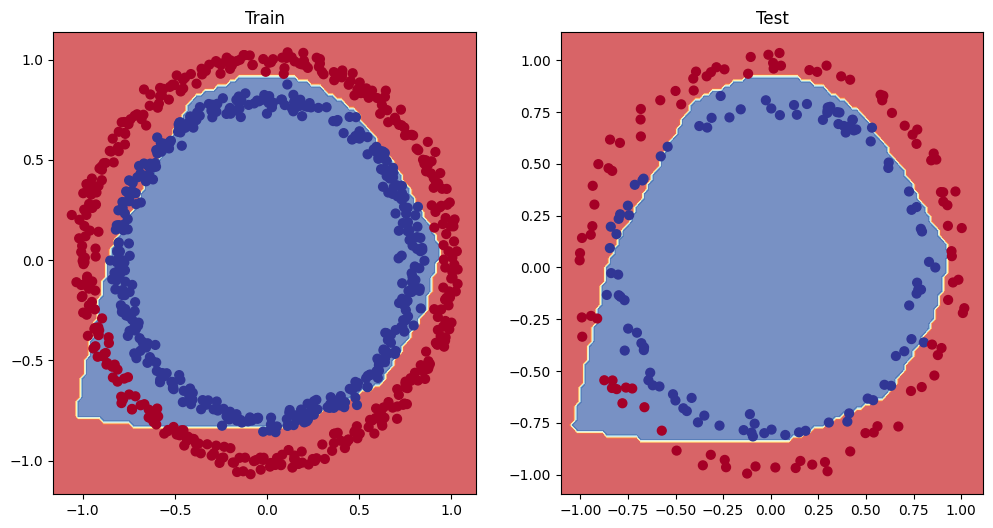

In [47]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

### 3. Replicating Non-Linear Activation Functions
- But what does a non-linear activation look like?
- How about we replicate some and what they do?

In [48]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

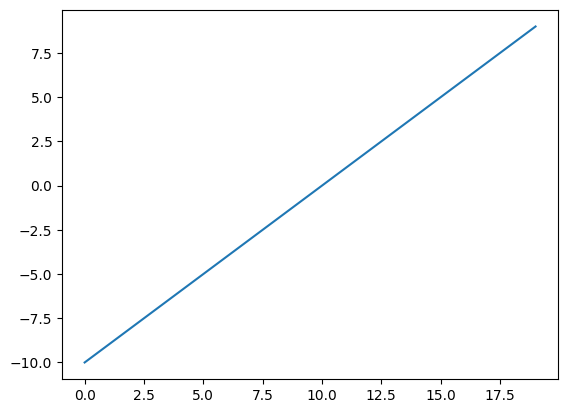

In [51]:
# Visualize the toy tensor
plt.plot(A);

##### ReLU
- Now let's see how the ReLU activation function influences it.
- And instead of using PyTorch's ReLU (torch.nn.ReLU), we'll recreate it ourselves.
- The ReLU function turns all negatives to 0 and leaves the positive values as they are.

In [52]:
# Create ReLU function by hand 
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

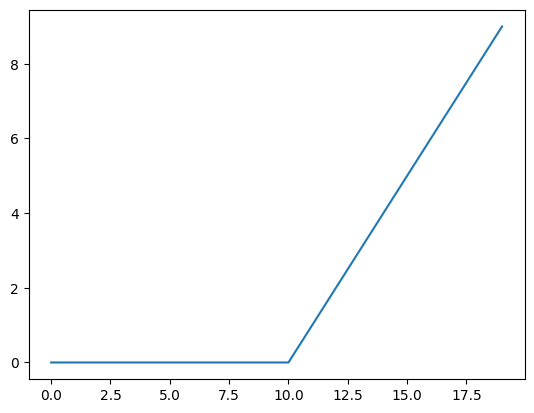

In [54]:
plt.plot(relu(A));

##### Sigmoid

In [59]:
def sigmoid(x):
    return 1 / (1+torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

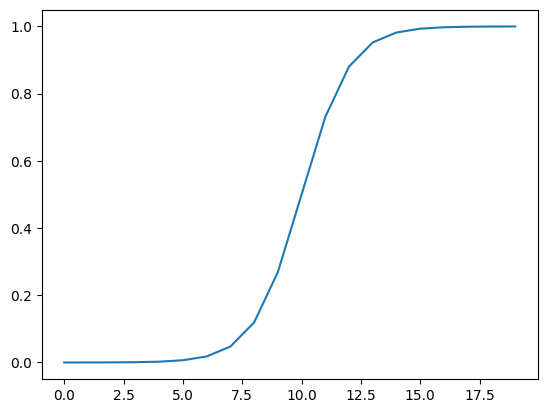

In [60]:
plt.plot(sigmoid(A))

#### Imp
-  what patterns could you draw using an unlimited amount of linear (straight) and non-linear (not straight) lines?  
    Almost anything

- That's exactly what our model is doing when we combine linear and non-linear functions.
- Instead of telling our model what to do, we give it tools to figure out how to best discover patterns in the data.
- And those tools are linear and non-linear functions.

# Putting things together by building a multi-class PyTorch model

### 1. Creating a multiclass data
- Create some multi-class data with `make_blobs()`.
- Turn the data into tensors (the default of `make_blobs()` is to use NumPy arrays).
- Split the data into training and test sets using `train_test_split()`.
- Visualize the data.


tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


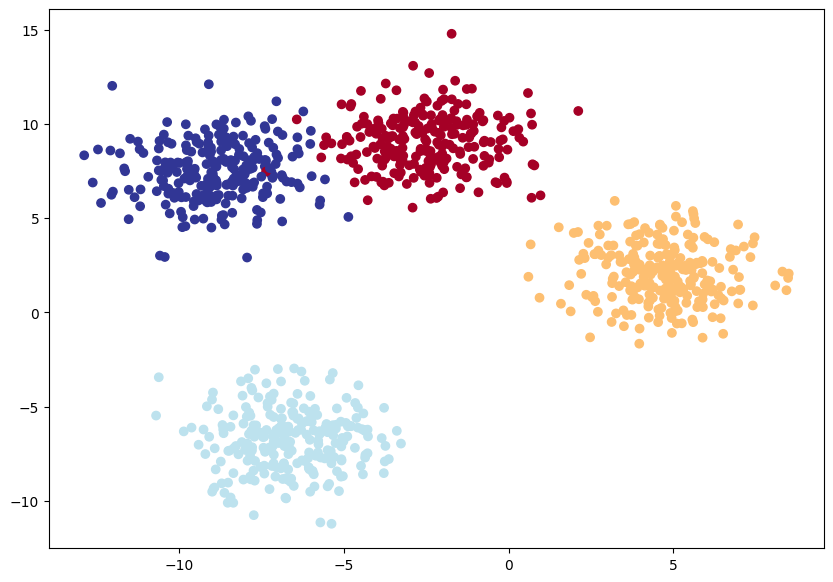

In [69]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 2. Model 

In [70]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [71]:
import torch.nn as nn

class BlobMoodel(nn.Module):
    def __init__(self, in_features, out_features, hidden_units=8):
        super().__init__()
        self.layer1 = nn.Linear(in_features=in_features, out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))


In [72]:
model_4 = BlobMoodel(in_features=NUM_FEATURES, out_features=NUM_CLASSES)
model_4 = model_4.to(device=device)
model_4

BlobMoodel(
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
)

### 3. Loss function and optimizer

In [73]:
#loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

### 4. forward pass on the test set

In [74]:
X_blob_train

tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        ...,
        [-1.7366,  9.7850],
        [-6.8139, -7.1006],
        [-9.0311,  4.5007]])

In [75]:
# with torch.inference_mode():
y_preds = model_4(X_blob_train.to(device))

In [76]:
#logits
y_preds[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [77]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

In [78]:
y_preds[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

- We get one value for each class per sample

In [79]:
torch.argmax(torch.softmax(y_preds, dim=1),dim=1)

tensor([1, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 1, 1, 3, 2, 2, 2, 3, 1,
        3, 2, 3, 3, 1, 3, 3, 1, 1, 3, 3, 2, 2, 3, 3, 3, 1, 1, 2, 3, 3, 3, 3, 3,
        1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 1, 3, 2, 1, 3, 2, 2, 2, 1, 3, 2,
        3, 3, 1, 1, 2, 3, 3, 1, 2, 3, 1, 3, 3, 2, 3, 3, 2, 2, 1, 3, 3, 3, 2, 1,
        3, 1, 2, 1, 3, 3, 3, 3, 2, 1, 2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2,
        3, 3, 2, 2, 3, 1, 2, 3, 3, 3, 2, 3, 2, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 2,
        3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
        2, 2, 2, 3, 3, 1, 1, 3, 1, 2, 3, 3, 2, 1, 3, 2, 3, 3, 3, 1, 3, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 2, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 2, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2,
        3, 2, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 1, 1, 1, 3, 1, 3, 1, 1, 3, 2,
        2, 3, 1, 3, 1, 2, 3, 1, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 1, 3,
        2, 2, 2, 2, 3, 1, 2, 2, 3, 2, 3,

In [80]:
y_blob_test.shape

torch.Size([200])

### 5. Creating a training and testing loop for a multi-class PyTorch model
- Turn logits to prediction probs(softmax) and to prediction labels(*argmax)

In [81]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):

    model_4.train()

    logits = model_4(X_blob_train)

    probs = torch.softmax(logits, dim=1)

    preds = torch.argmax(probs, dim=1)

    loss = loss_fn(logits, y_blob_train)   #cross entropy loss takes logits and it uses softmax and argmax on its own

    train_accuracy = accuracy_fn(y_true=y_blob_train, y_pred=preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_4.eval()

    with torch.inference_mode():

        test_logits = model_4(X_blob_test)

        probs_test = torch.softmax(test_logits, dim=1)

        preds_test = torch.argmax(probs_test, dim=1)

        loss_test = loss_fn(test_logits, y_blob_test)   #cross entropy loss takes logits and it uses softmax and argmax on its own

        test_accuracy = accuracy_fn(y_true=y_blob_test, y_pred=preds_test)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {train_accuracy:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {test_accuracy:.2f}%")

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


### 6. Making and evaluating predictions with a PyTorch multi-class model